In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from control import *

In [26]:
r1 = 10E3
r2 = 33E3
c1 = 1E-6
c2 = 1E-6

In [35]:
# 1) Crear una planta mediante los coeficientes del denominador y numerador en el tiempo continuo
s = tf('s') # Crea el operador diferencial S que se utiliza en las funciones transferencia
h_s = 1 / (1 + r1*c1*r2*c2*s*s + (r1*c1 + r2*c2 + r1*c2)*s)
num, den = tfdata(h_s)

# 2) Crear una planta mediante matrices de estados que la definen (A, B, C y D)
# Se tiene que usar una conversion hecha por la libreria control con tf2ss (transfer function to state space)
# Se separa numerador y denominador de la funcion transferencia primero (esto se hizo con tfdata)
h_ss = tf2ss(num,den)


In [36]:
# 3) Discretizar las anteriores plantas
# Para discretizar primero se tiene que definir un h que es el tiempo entre muestra y muestra
sys = ss2tf(h_ss.A,h_ss.B,h_ss.C,h_ss.D)
h = 0.1
#       (Funcion transferencia continua, periodo de muestreo, tipo de retardo)
hz = matlab.c2d(h_s, h, 'zoh')

# Obtengo los valores de numerador y denominador
numz, denz = tfdata(hz)

# Obtengo la ecuacion en espacio de estados
h_sz = tf2ss(hz)

polos [1.12623756e-01+0.j 9.40453671e-07+0.j] ceros [-0.0242761+0.j]


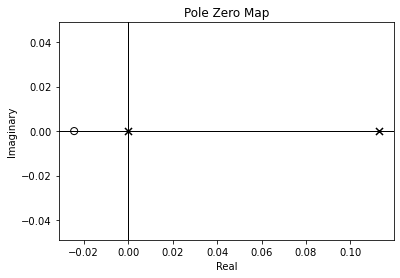

In [42]:
# 4) Evaluar la distribucion de polos y ceros de las plantas continuas y discretas, tambien su respuesta en frecuencia
# Polos y ceros en tiempo discreto
polosz, cerosz = pzmap(hz)
print("polos",polosz,"ceros",cerosz)

polos [-138.76903449+0.j  -21.83702612+0.j] ceros []


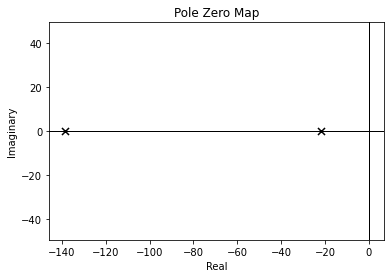

In [43]:
# Polos y ceros en el tiempo continuo
polosc, cerosc = pzmap(h_s)
print("polos",polosc,"ceros",cerosc)

(array([0.99892717, 0.99891226, 0.99889714, 0.9988818 , 0.99886626,
        0.9988505 , 0.99883452, 0.99881831, 0.99880189, 0.99878523,
        0.99876835, 0.99875123, 0.99873387, 0.99871627, 0.99869843,
        0.99868034, 0.998662  , 0.9986434 , 0.99862455, 0.99860543,
        0.99858605, 0.9985664 , 0.99854648, 0.99852628, 0.99850581,
        0.99848504, 0.998464  , 0.99844265, 0.99842102, 0.99839908,
        0.99837684, 0.99835429, 0.99833143, 0.99830825, 0.99828475,
        0.99826093, 0.99823677, 0.99821228, 0.99818745, 0.99816228,
        0.99813676, 0.99811088, 0.99808465, 0.99805805, 0.99803108,
        0.99800375, 0.99797603, 0.99794793, 0.99791944, 0.99789056,
        0.99786127, 0.99783158, 0.99780148, 0.99777097, 0.99774003,
        0.99770866, 0.99767686, 0.99764462, 0.99761194, 0.9975788 ,
        0.9975452 , 0.99751114, 0.99747661, 0.9974416 , 0.99740611,
        0.99737013, 0.99733365, 0.99729666, 0.99725917, 0.99722115,
        0.99718261, 0.99714354, 0.99710393, 0.99

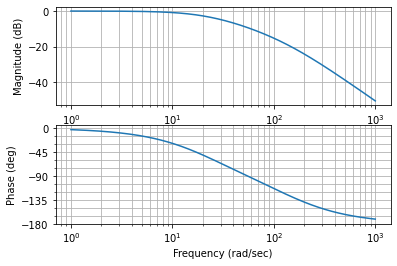

In [44]:
# Respuesta en frecuencia del sistema en tiempo continuo
bode_plot(h_s)

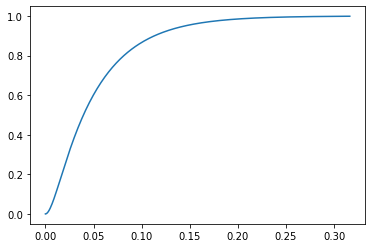

In [47]:
# 5) Evaluar la respuesta al escalon de todas las plantas, continuas y discretas
# Tiempo continuo
t, out = step_response(h_s)
plt.plot(t, out)

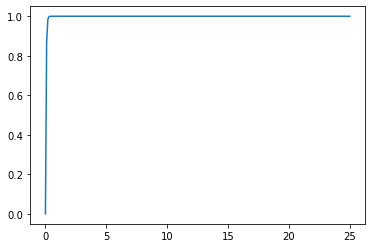

In [48]:
# Tiempo discreto
t, out = step_response(hz)
plt.plot(t, out)

coefs b -> [1 2 0]
coefs a -> [ 1 -2  1]
y[0] = 2.0
y[1] = 5.0
y[2] = 11.0
y[3] = 20.0
y[4] = 32.0
y[5] = 47.0
y[6] = 65.0
y[7] = 86.0
y[8] = 110.0
y[9] = 137.0
y[10] = 167.0
y[11] = 200.0
y[12] = 236.0
y[13] = 275.0
y[14] = 317.0
y[15] = 362.0
y[16] = 410.0
y[17] = 461.0
y[18] = 515.0
y[19] = 572.0
y[20] = 632.0
y[21] = 695.0
y[22] = 761.0
y[23] = 830.0
y[24] = 902.0
y[25] = 977.0
y[26] = 1055.0
y[27] = 1136.0
y[28] = 1220.0
y[29] = 1307.0
y[30] = 1397.0


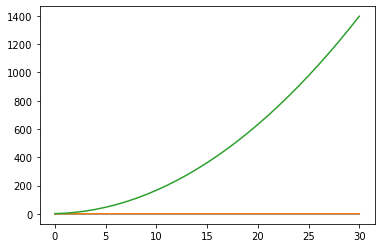

In [157]:
# 6) Crear una funcion que aplique la ecuacion de recurrencia de un filtro a una entrada cualquiera
def funcion_recurrencia(num: np.ndarray, den: np.ndarray, input: np.ndarray) -> np.ndarray:
    # len(num), len(den)
    u = input
    b = num
    a = den
    num_len = len(num)
    den_len = len(den)
    y = np.zeros(len(u))

    # a = np.flip(a)

    print("coefs b -> {}".format(num))
    print("coefs a -> {}".format(den))
    # Para el denominador o los Bn
    # den[0]*input[n] + den[1]*input[n-1] + den[2]*input[n-2] + .. +

    for k in range(len(y)):
        # print("K = {}".format(k))
        num_terms = np.array([])
        den_terms = np.array([])
        for Nb in range(len(num)):
            #b(Nb)u(n−Nb+1)
            num_terms = np.append(num_terms, b[Nb] * u[k - Nb + 1 - 1])
            # print("B -> {} * {} = {}".format(b[Nb],u[k - Nb + 1 - 1],num_terms[Nb]))

        for Na in range(1,len(den)):
            #a(Na)y(n−Na+1)
            den_terms = np.append(den_terms, a[Na] * y[k - Na + 1 - 1])
            # print("A -> {} * {} = {}".format(a[Na],y[k - Na + 1 - 1],den_terms[Na - 1]))

        y[k] = (np.sum(num_terms) - np.sum(den_terms))/(a[len(a) - 1])
        print("y[{}] = {}".format(k,y[k]))
    return y

impulso = np.zeros(31)
impulso[0] = 1
plt.plot(range(len(impulso)),impulso)

escalon = np.ones(31)
escalon[0] = 0
plt.plot(range(len(escalon)),escalon)

y = funcion_recurrencia(num,den,escalon)

# print(y)
plt.plot(range(len(y)),y)
